In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/WhenPigsFlyContext/baselines/Detectron2

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/WhenPigsFlyContext/baselines/Detectron2


In [2]:
%%capture
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install ml-collections

In [22]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.structures import Boxes, ImageList, Instances, pairwise_iou
import detectron2.data.transforms as T

# import pytorch
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image, to_tensor

from PIL import Image
from tqdm import tqdm, trange
import copy
import pickle
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append("..")

from coco.dataset import COCODataset
from utils import *

In [4]:
# transform attention map from rgb to grayscale
transform_single = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ]
) 

# change PIL image to pytorch tensor
img_transforms = transforms.Compose(
    [
        transforms.Resize((800, 1280)),
        transforms.ToTensor(),
    ]
)

# process predicted objectiveness logits to range(0, 1)
sigmoid = torch.nn.Sigmoid()

Load the detectron2 model pretrained on coco stuff 

In [5]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

predictor = DefaultPredictor(cfg)
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

model_final_f10217.pkl: 178MB [00:05, 35.1MB/s]                           


{'__author__': 'Detectron2 Model Zoo'}

In [ ]:
#@title Demo of Detectron2
im = cv2.imread("./baselines/000000003877.jpg")
# cv2_imshow(im)
outputs = predictor(im)
print(outputs["instances"].pred_classes)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#@title Sample code of detectron2 { display-mode: "form" }
inputs = [{"image": img_tensor, "height": height, "width": width}]
model.eval()
with torch.no_grad():
    outputs = model(inputs)

outputs

mask_features = [features[f] for f in model.roi_heads.in_features]
mask_features = model.roi_heads.mask_pooler(mask_features, [x.pred_boxes for x in instances])
mask_features.shape

In [12]:
%%capture
test_annotations = "../../debug/coco18_test.json"
test_imagedir = "../../coco18_test"
image_list = os.listdir(test_imagedir)
input_images = COCODataset(test_annotations, test_imagedir, image_size=(224,224))

img_size = (320, 512)
tg_bbox_dic = {}

for id in trange(len(input_images)):
    _, _, bbox, labels_cpu = input_images[id]
    
    file_name_full = input_images.id2file[input_images.annotations[id]['image_id']]
    file_name = file_name_full.split('/')[-1]

    tg_loc = bbox_cordinates(bbox, img_size[1], img_size[0])
    tg_bbox_dic[file_name] = tg_loc

In [20]:
detectron2_res, size = [], 48
detectron2_attention_map, scanpath = {}, {}

for id in trange(len(image_list)):
    # get the target bounding box
    tg_loc = tg_bbox_dic[image_list[id]]

    # get the img path
    img_dir = os.path.join(test_imagedir, image_list[id]) 
    img = cv2.imread(img_dir)
    image = aug.get_transform(img).apply_image(img)
    img_tensor = torch.as_tensor(image.astype("float32").transpose(2, 0, 1)).cuda()
    imgList = ImageList.from_tensors([img_tensor])

    # compute the attention map
    model.eval()
    with torch.no_grad():
        features = model.backbone(img_tensor.unsqueeze(0))
        mask_features = [features[f] for f in features.keys()]
        pred_objectness_logits, _ = model.proposal_generator.rpn_head(mask_features)

    attention_map = torch.zeros((3, 320, 512)).detach().cuda()
    for i in range(len(pred_objectness_logits)):
        logits = transforms.Resize(img_size)(pred_objectness_logits[i].squeeze(0)).cuda()
        logits = sigmoid(logits)
        attention_map += logits

    attention_map = attention_map/len(pred_objectness_logits)
    attention_map = torch.divide(attention_map, attention_map.max())
    attention_map = transform_single(to_pil_image(attention_map))

    detectron2_attention_map[image_list[id]] = copy.deepcopy(attention_map)

    search_num, path = searchProcesswithPath(tg_loc, attention_map, img_size, size)
    scanpath[image_list[id]] = path

    print(search_num, '\n')
    detectron2_res.append(search_num)

  0%|          | 2/612 [00:00<01:51,  5.49it/s]

61 

9 



  1%|          | 4/612 [00:00<01:39,  6.11it/s]

5 

13 



  1%|          | 6/612 [00:00<01:33,  6.45it/s]

2 

3 



  1%|▏         | 8/612 [00:01<01:32,  6.54it/s]

2 

3 



  2%|▏         | 10/612 [00:01<01:36,  6.23it/s]

14 

2 



  2%|▏         | 12/612 [00:01<01:37,  6.17it/s]

2 

19 



  2%|▏         | 14/612 [00:02<01:33,  6.39it/s]

3 

2 



  3%|▎         | 16/612 [00:02<01:31,  6.49it/s]

32 

6 



  3%|▎         | 18/612 [00:02<01:31,  6.50it/s]

6 

5 



  3%|▎         | 20/612 [00:03<01:30,  6.52it/s]

9 

2 



  4%|▎         | 22/612 [00:03<01:33,  6.33it/s]

38 

11 



  4%|▍         | 24/612 [00:03<01:31,  6.46it/s]

9 

6 



  4%|▍         | 26/612 [00:04<01:29,  6.55it/s]

6 

8 



  5%|▍         | 28/612 [00:04<01:28,  6.62it/s]

3 

2 



  5%|▍         | 30/612 [00:04<01:29,  6.53it/s]

41 

2 



  5%|▌         | 32/612 [00:05<01:27,  6.60it/s]

2 

2 



  6%|▌         | 34/612 [00:05<01:26,  6.67it/s]

3 

3 



  6%|▌         | 36/612 [00:05<01:26,  6.62it/s]

15 

4 



  6%|▌         | 38/612 [00:05<01:28,  6.46it/s]

9 

56 



  7%|▋         | 40/612 [00:06<01:26,  6.61it/s]

4 

2 



  7%|▋         | 42/612 [00:06<01:26,  6.61it/s]

4 

2 



  7%|▋         | 44/612 [00:06<01:26,  6.55it/s]

5 

9 



  8%|▊         | 46/612 [00:07<01:24,  6.66it/s]

2 

7 



  8%|▊         | 48/612 [00:07<01:25,  6.60it/s]

7 

7 



  8%|▊         | 50/612 [00:07<01:25,  6.58it/s]

21 

3 



  8%|▊         | 52/612 [00:08<01:25,  6.59it/s]

4 

12 



  9%|▉         | 54/612 [00:08<01:26,  6.46it/s]

5 

67 



  9%|▉         | 56/612 [00:08<01:26,  6.42it/s]

12 

16 



  9%|▉         | 58/612 [00:08<01:25,  6.45it/s]

2 

16 



 10%|▉         | 60/612 [00:09<01:24,  6.56it/s]

2 

2 



 10%|█         | 62/612 [00:09<01:24,  6.48it/s]

41 

2 



 10%|█         | 64/612 [00:09<01:23,  6.55it/s]

3 

5 



 11%|█         | 66/612 [00:10<01:22,  6.61it/s]

21 

9 



 11%|█         | 68/612 [00:10<01:23,  6.54it/s]

7 

4 



 11%|█▏        | 70/612 [00:10<01:22,  6.57it/s]

6 

5 



 12%|█▏        | 72/612 [00:11<01:21,  6.60it/s]

8 

2 



 12%|█▏        | 74/612 [00:11<01:22,  6.48it/s]

48 

25 



 12%|█▏        | 76/612 [00:11<01:21,  6.56it/s]

11 

2 



 13%|█▎        | 78/612 [00:12<01:21,  6.55it/s]

3 

12 



 13%|█▎        | 80/612 [00:12<01:21,  6.50it/s]

31 

2 



 13%|█▎        | 82/612 [00:12<01:21,  6.54it/s]

6 

9 



 14%|█▎        | 84/612 [00:12<01:19,  6.60it/s]

2 

3 



 14%|█▍        | 86/612 [00:13<01:21,  6.49it/s]

25 

19 



 14%|█▍        | 88/612 [00:13<01:20,  6.50it/s]

3 

29 



 15%|█▍        | 90/612 [00:13<01:18,  6.61it/s]

2 

3 



 15%|█▌        | 92/612 [00:14<01:19,  6.50it/s]

5 

13 



 15%|█▌        | 94/612 [00:14<01:22,  6.30it/s]

14 

24 



 16%|█▌        | 96/612 [00:14<01:20,  6.43it/s]

2 

3 



 16%|█▌        | 98/612 [00:15<01:19,  6.50it/s]

26 

2 



 16%|█▋        | 100/612 [00:15<01:18,  6.50it/s]

2 

3 



 17%|█▋        | 102/612 [00:15<01:18,  6.50it/s]

2 

2 



 17%|█▋        | 104/612 [00:16<01:19,  6.41it/s]

34 

2 



 17%|█▋        | 106/612 [00:16<01:18,  6.47it/s]

3 

2 



 18%|█▊        | 108/612 [00:16<01:17,  6.50it/s]

11 

4 



 18%|█▊        | 110/612 [00:16<01:20,  6.27it/s]

10 

54 



 18%|█▊        | 112/612 [00:17<01:18,  6.39it/s]

2 

3 



 19%|█▊        | 114/612 [00:17<01:16,  6.48it/s]

2 

6 



 19%|█▉        | 116/612 [00:17<01:16,  6.46it/s]

3 

8 



 19%|█▉        | 118/612 [00:18<01:16,  6.46it/s]

2 

12 



 20%|█▉        | 120/612 [00:18<01:18,  6.31it/s]

16 

5 



 20%|█▉        | 122/612 [00:18<01:16,  6.42it/s]

2 

8 



 20%|██        | 124/612 [00:19<01:16,  6.38it/s]

9 

28 



 21%|██        | 126/612 [00:19<01:16,  6.34it/s]

2 

9 



 21%|██        | 128/612 [00:19<01:15,  6.43it/s]

2 

7 



 21%|██        | 130/612 [00:20<01:14,  6.46it/s]

2 

6 



 22%|██▏       | 132/612 [00:20<01:13,  6.53it/s]

6 

2 



 22%|██▏       | 134/612 [00:20<01:14,  6.40it/s]

61 

2 



 22%|██▏       | 136/612 [00:21<01:14,  6.37it/s]

58 

4 



 23%|██▎       | 138/612 [00:21<01:14,  6.39it/s]

16 

7 



 23%|██▎       | 140/612 [00:21<01:14,  6.38it/s]

7 

27 



 23%|██▎       | 142/612 [00:21<01:12,  6.44it/s]

2 

4 



 24%|██▎       | 144/612 [00:22<01:11,  6.52it/s]

2 

2 



 24%|██▍       | 146/612 [00:22<01:12,  6.42it/s]

27 

4 



 24%|██▍       | 148/612 [00:22<01:12,  6.39it/s]

3 

3 



 25%|██▍       | 150/612 [00:23<01:11,  6.46it/s]

8 

2 



 25%|██▍       | 152/612 [00:23<01:10,  6.50it/s]

8 

7 



 25%|██▌       | 154/612 [00:23<01:09,  6.56it/s]

3 

5 



 25%|██▌       | 156/612 [00:24<01:09,  6.55it/s]

8 

3 



 26%|██▌       | 158/612 [00:24<01:10,  6.47it/s]

3 

4 



 26%|██▌       | 160/612 [00:24<01:09,  6.52it/s]

3 

3 



 26%|██▋       | 162/612 [00:25<01:09,  6.50it/s]

2 

6 



 27%|██▋       | 164/612 [00:25<01:08,  6.50it/s]

8 

3 



 27%|██▋       | 166/612 [00:25<01:09,  6.38it/s]

15 

38 



 27%|██▋       | 168/612 [00:25<01:09,  6.36it/s]

8 

18 



 28%|██▊       | 170/612 [00:26<01:09,  6.35it/s]

3 

43 



 28%|██▊       | 172/612 [00:26<01:08,  6.41it/s]

2 

2 



 28%|██▊       | 174/612 [00:26<01:08,  6.42it/s]

2 

15 



 29%|██▉       | 176/612 [00:27<01:06,  6.52it/s]

8 

2 



 29%|██▉       | 178/612 [00:27<01:08,  6.30it/s]

9 

45 



 29%|██▉       | 180/612 [00:27<01:07,  6.37it/s]

25 

3 



 30%|██▉       | 182/612 [00:28<01:06,  6.43it/s]

7 

14 



 30%|███       | 184/612 [00:28<01:06,  6.47it/s]

2 

4 



 30%|███       | 186/612 [00:28<01:06,  6.44it/s]

2 

2 



 31%|███       | 188/612 [00:29<01:06,  6.39it/s]

3 

36 



 31%|███       | 190/612 [00:29<01:05,  6.41it/s]

21 

3 



 31%|███▏      | 192/612 [00:29<01:04,  6.47it/s]

8 

2 



 32%|███▏      | 194/612 [00:30<01:05,  6.42it/s]

9 

19 



 32%|███▏      | 196/612 [00:30<01:03,  6.55it/s]

2 

2 



 32%|███▏      | 198/612 [00:30<01:03,  6.53it/s]

2 

5 



 33%|███▎      | 200/612 [00:30<01:03,  6.53it/s]

3 

6 



 33%|███▎      | 202/612 [00:31<01:02,  6.55it/s]

5 

2 



 33%|███▎      | 204/612 [00:31<01:02,  6.48it/s]

4 

14 



 34%|███▎      | 206/612 [00:31<01:03,  6.35it/s]

10 

42 



 34%|███▍      | 208/612 [00:32<01:03,  6.40it/s]

3 

4 



 34%|███▍      | 210/612 [00:32<01:02,  6.47it/s]

5 

2 



 35%|███▍      | 212/612 [00:32<01:02,  6.43it/s]

13 

2 



 35%|███▍      | 214/612 [00:33<01:01,  6.43it/s]

2 

8 



 35%|███▌      | 216/612 [00:33<01:01,  6.48it/s]

3 

2 



 36%|███▌      | 218/612 [00:33<01:01,  6.46it/s]

8 

2 



 36%|███▌      | 220/612 [00:34<01:00,  6.49it/s]

6 

5 



 36%|███▋      | 222/612 [00:34<00:59,  6.52it/s]

7 

3 



 37%|███▋      | 224/612 [00:34<01:00,  6.46it/s]

2 

8 



 37%|███▋      | 226/612 [00:34<00:59,  6.47it/s]

5 

10 



 37%|███▋      | 228/612 [00:35<00:58,  6.54it/s]

3 

2 



 38%|███▊      | 230/612 [00:35<00:58,  6.52it/s]

3 

2 



 38%|███▊      | 232/612 [00:35<00:58,  6.52it/s]

11 

11 



 38%|███▊      | 234/612 [00:36<00:59,  6.36it/s]

29 

10 



 39%|███▊      | 236/612 [00:36<00:58,  6.41it/s]

10 

12 



 39%|███▉      | 238/612 [00:36<00:57,  6.47it/s]

25 

2 



 39%|███▉      | 240/612 [00:37<00:57,  6.42it/s]

2 

9 



 40%|███▉      | 242/612 [00:37<00:57,  6.43it/s]

5 

22 



 40%|███▉      | 244/612 [00:37<00:56,  6.52it/s]

5 

3 



 40%|████      | 246/612 [00:38<00:56,  6.52it/s]

3 

8 



 41%|████      | 248/612 [00:38<00:56,  6.40it/s]

69 

8 



 41%|████      | 250/612 [00:38<00:56,  6.42it/s]

2 

5 



 41%|████      | 252/612 [00:39<00:56,  6.43it/s]

2 

12 



 42%|████▏     | 254/612 [00:39<00:57,  6.26it/s]

22 

50 



 42%|████▏     | 256/612 [00:39<00:56,  6.32it/s]

4 

4 



 42%|████▏     | 258/612 [00:39<00:54,  6.46it/s]

2 

2 



 42%|████▏     | 260/612 [00:40<00:54,  6.48it/s]

2 

2 



 43%|████▎     | 262/612 [00:40<00:54,  6.44it/s]

14 

6 



 43%|████▎     | 264/612 [00:40<00:53,  6.51it/s]

2 

5 



 43%|████▎     | 266/612 [00:41<00:53,  6.46it/s]

14 

3 



 44%|████▍     | 268/612 [00:41<00:53,  6.45it/s]

13 

2 



 44%|████▍     | 270/612 [00:41<00:52,  6.47it/s]

9 

4 



 44%|████▍     | 272/612 [00:42<00:52,  6.49it/s]

2 

4 



 45%|████▍     | 274/612 [00:42<00:51,  6.55it/s]

11 

2 



 45%|████▌     | 276/612 [00:42<00:51,  6.50it/s]

2 

38 



 45%|████▌     | 278/612 [00:43<00:50,  6.57it/s]

2 

2 



 46%|████▌     | 280/612 [00:43<00:50,  6.60it/s]

4 

7 



 46%|████▌     | 282/612 [00:43<00:50,  6.57it/s]

2 

5 



 46%|████▋     | 284/612 [00:43<00:50,  6.45it/s]

8 

6 



 47%|████▋     | 286/612 [00:44<00:50,  6.49it/s]

3 

12 



 47%|████▋     | 288/612 [00:44<00:49,  6.57it/s]

3 

3 



 47%|████▋     | 290/612 [00:44<00:49,  6.54it/s]

2 

3 



 48%|████▊     | 292/612 [00:45<00:48,  6.54it/s]

7 

7 



 48%|████▊     | 294/612 [00:45<00:48,  6.52it/s]

11 

4 



 48%|████▊     | 296/612 [00:45<00:48,  6.45it/s]

13 

13 



 49%|████▊     | 298/612 [00:46<00:49,  6.36it/s]

15 

38 



 49%|████▉     | 300/612 [00:46<00:48,  6.48it/s]

4 

3 



 49%|████▉     | 302/612 [00:46<00:47,  6.52it/s]

3 

6 



 50%|████▉     | 304/612 [00:47<00:47,  6.52it/s]

3 

4 



 50%|█████     | 306/612 [00:47<00:47,  6.45it/s]

3 

14 



 50%|█████     | 308/612 [00:47<00:47,  6.46it/s]

8 

7 



 51%|█████     | 310/612 [00:47<00:46,  6.45it/s]

2 

16 



 51%|█████     | 312/612 [00:48<00:46,  6.40it/s]

32 

7 



 51%|█████▏    | 314/612 [00:48<00:46,  6.43it/s]

7 

2 



 52%|█████▏    | 316/612 [00:48<00:47,  6.28it/s]

70 

16 



 52%|█████▏    | 318/612 [00:49<00:46,  6.35it/s]

12 

5 



 52%|█████▏    | 320/612 [00:49<00:46,  6.26it/s]

45 

23 



 53%|█████▎    | 322/612 [00:49<00:45,  6.44it/s]

2 

4 



 53%|█████▎    | 324/612 [00:50<00:44,  6.44it/s]

14 

2 



 53%|█████▎    | 326/612 [00:50<00:43,  6.55it/s]

3 

3 



 54%|█████▎    | 328/612 [00:50<00:43,  6.56it/s]

2 

25 



 54%|█████▍    | 330/612 [00:51<00:43,  6.55it/s]

16 

7 



 54%|█████▍    | 332/612 [00:51<00:42,  6.54it/s]

8 

3 



 55%|█████▍    | 334/612 [00:51<00:42,  6.57it/s]

5 

7 



 55%|█████▍    | 336/612 [00:52<00:43,  6.27it/s]

60 

2 



 55%|█████▌    | 338/612 [00:52<00:43,  6.30it/s]

5 

19 



 56%|█████▌    | 340/612 [00:52<00:42,  6.36it/s]

4 

4 



 56%|█████▌    | 342/612 [00:52<00:42,  6.33it/s]

2 

8 



 56%|█████▌    | 344/612 [00:53<00:42,  6.35it/s]

2 

18 



 57%|█████▋    | 346/612 [00:53<00:42,  6.31it/s]

18 

2 



 57%|█████▋    | 348/612 [00:53<00:41,  6.32it/s]

10 

5 



 57%|█████▋    | 350/612 [00:54<00:41,  6.34it/s]

9 

2 



 58%|█████▊    | 352/612 [00:54<00:41,  6.33it/s]

21 

2 



 58%|█████▊    | 354/612 [00:54<00:40,  6.35it/s]

2 

8 



 58%|█████▊    | 356/612 [00:55<00:41,  6.22it/s]

14 

17 



 58%|█████▊    | 358/612 [00:55<00:40,  6.26it/s]

2 

2 



 59%|█████▉    | 360/612 [00:55<00:40,  6.29it/s]

2 

4 



 59%|█████▉    | 362/612 [00:56<00:39,  6.34it/s]

7 

5 



 59%|█████▉    | 364/612 [00:56<00:38,  6.38it/s]

3 

3 



 60%|█████▉    | 366/612 [00:56<00:38,  6.39it/s]

7 

5 



 60%|██████    | 368/612 [00:57<00:39,  6.25it/s]

2 

2 



 60%|██████    | 370/612 [00:57<00:38,  6.31it/s]

4 

6 



 61%|██████    | 372/612 [00:57<00:38,  6.31it/s]

7 

2 



 61%|██████    | 374/612 [00:58<00:36,  6.48it/s]

2 

2 



 61%|██████▏   | 376/612 [00:58<00:36,  6.45it/s]

3 

13 



 62%|██████▏   | 378/612 [00:58<00:37,  6.24it/s]

6 

87 



 62%|██████▏   | 380/612 [00:58<00:36,  6.44it/s]

7 

4 



 62%|██████▏   | 382/612 [00:59<00:35,  6.48it/s]

6 

7 



 63%|██████▎   | 384/612 [00:59<00:34,  6.55it/s]

2 

9 



 63%|██████▎   | 386/612 [00:59<00:35,  6.42it/s]

5 

45 



 63%|██████▎   | 388/612 [01:00<00:34,  6.52it/s]

10 

5 



 64%|██████▎   | 390/612 [01:00<00:34,  6.44it/s]

13 

11 



 64%|██████▍   | 392/612 [01:00<00:34,  6.44it/s]

12 

4 



 64%|██████▍   | 394/612 [01:01<00:34,  6.35it/s]

2 

3 



 65%|██████▍   | 396/612 [01:01<00:34,  6.18it/s]

2 

3 



 65%|██████▍   | 397/612 [01:01<00:34,  6.21it/s]

5 



 65%|██████▌   | 399/612 [01:02<00:39,  5.44it/s]

23 

3 



 66%|██████▌   | 401/612 [01:02<00:36,  5.75it/s]

2 

3 



 66%|██████▌   | 403/612 [01:02<00:36,  5.66it/s]

5 

46 



 66%|██████▌   | 405/612 [01:03<00:34,  6.01it/s]

3 

7 



 67%|██████▋   | 407/612 [01:03<00:32,  6.27it/s]

12 

11 



 67%|██████▋   | 409/612 [01:03<00:32,  6.17it/s]

9 

35 



 67%|██████▋   | 411/612 [01:04<00:32,  6.23it/s]

4 

66 



 67%|██████▋   | 413/612 [01:04<00:31,  6.42it/s]

15 

9 



 68%|██████▊   | 415/612 [01:04<00:30,  6.50it/s]

2 

2 



 68%|██████▊   | 417/612 [01:04<00:30,  6.40it/s]

3 

9 



 68%|██████▊   | 419/612 [01:05<00:32,  5.93it/s]

45 

2 



 69%|██████▉   | 421/612 [01:05<00:32,  5.90it/s]

9 

2 



 69%|██████▉   | 423/612 [01:05<00:30,  6.16it/s]

5 

5 



 69%|██████▉   | 425/612 [01:06<00:30,  6.20it/s]

4 

4 



 70%|██████▉   | 427/612 [01:06<00:31,  5.90it/s]

72 

2 



 70%|███████   | 429/612 [01:06<00:29,  6.12it/s]

10 

2 



 70%|███████   | 431/612 [01:07<00:29,  6.13it/s]

6 

10 



 71%|███████   | 433/612 [01:07<00:28,  6.23it/s]

49 

4 



 71%|███████   | 435/612 [01:07<00:27,  6.43it/s]

4 

8 



 71%|███████▏  | 437/612 [01:08<00:28,  6.13it/s]

5 

10 



 72%|███████▏  | 439/612 [01:08<00:27,  6.33it/s]

9 

2 



 72%|███████▏  | 441/612 [01:08<00:28,  6.07it/s]

3 

73 



 72%|███████▏  | 443/612 [01:09<00:28,  5.89it/s]

2 

39 



 73%|███████▎  | 445/612 [01:09<00:27,  6.07it/s]

3 

5 



 73%|███████▎  | 447/612 [01:09<00:26,  6.15it/s]

23 

15 



 73%|███████▎  | 449/612 [01:10<00:25,  6.36it/s]

5 

2 



 74%|███████▎  | 451/612 [01:10<00:25,  6.24it/s]

74 

20 



 74%|███████▍  | 453/612 [01:10<00:24,  6.38it/s]

37 

2 



 74%|███████▍  | 455/612 [01:11<00:24,  6.45it/s]

2 

3 



 75%|███████▍  | 457/612 [01:11<00:23,  6.49it/s]

3 

7 



 75%|███████▌  | 459/612 [01:11<00:23,  6.57it/s]

10 

2 



 75%|███████▌  | 461/612 [01:12<00:22,  6.64it/s]

2 

2 



 76%|███████▌  | 463/612 [01:12<00:22,  6.56it/s]

14 

2 



 76%|███████▌  | 465/612 [01:12<00:23,  6.39it/s]

3 

2 



 76%|███████▋  | 467/612 [01:12<00:22,  6.35it/s]

4 

2 



 77%|███████▋  | 469/612 [01:13<00:22,  6.40it/s]

2 

3 



 77%|███████▋  | 471/612 [01:13<00:21,  6.47it/s]

2 

2 



 77%|███████▋  | 473/612 [01:13<00:21,  6.56it/s]

3 

10 



 78%|███████▊  | 475/612 [01:14<00:20,  6.60it/s]

2 

3 



 78%|███████▊  | 477/612 [01:14<00:20,  6.48it/s]

7 

5 



 78%|███████▊  | 479/612 [01:14<00:20,  6.59it/s]

2 

3 



 79%|███████▊  | 481/612 [01:15<00:20,  6.53it/s]

33 

4 



 79%|███████▉  | 483/612 [01:15<00:19,  6.50it/s]

4 

13 



 79%|███████▉  | 485/612 [01:15<00:19,  6.51it/s]

2 

2 



 80%|███████▉  | 487/612 [01:16<00:19,  6.39it/s]

2 

38 



 80%|███████▉  | 489/612 [01:16<00:19,  6.40it/s]

13 

2 



 80%|████████  | 491/612 [01:16<00:18,  6.39it/s]

2 

17 



 81%|████████  | 493/612 [01:16<00:18,  6.44it/s]

3 

20 



 81%|████████  | 495/612 [01:17<00:18,  6.17it/s]

25 

77 



 81%|████████  | 497/612 [01:17<00:18,  6.19it/s]

2 

12 



 82%|████████▏ | 499/612 [01:17<00:18,  6.24it/s]

7 

6 



 82%|████████▏ | 501/612 [01:18<00:17,  6.31it/s]

7 

18 



 82%|████████▏ | 503/612 [01:18<00:17,  6.08it/s]

11 

76 



 83%|████████▎ | 505/612 [01:18<00:17,  6.22it/s]

4 

6 



 83%|████████▎ | 507/612 [01:19<00:16,  6.23it/s]

3 

2 



 83%|████████▎ | 509/612 [01:19<00:16,  6.30it/s]

10 

4 



 83%|████████▎ | 511/612 [01:19<00:15,  6.32it/s]

2 

6 



 84%|████████▎ | 512/612 [01:20<00:15,  6.26it/s]

3 



 84%|████████▍ | 513/612 [01:20<00:17,  5.74it/s]

36 



 84%|████████▍ | 514/612 [01:20<00:18,  5.24it/s]

40 



 84%|████████▍ | 515/612 [01:20<00:22,  4.38it/s]

2 



 84%|████████▍ | 517/612 [01:21<00:20,  4.72it/s]

2 

2 



 85%|████████▍ | 519/612 [01:21<00:17,  5.39it/s]

2 

2 



 85%|████████▌ | 521/612 [01:21<00:15,  5.80it/s]

9 

2 



 85%|████████▌ | 523/612 [01:22<00:14,  5.98it/s]

8 

8 



 86%|████████▌ | 525/612 [01:22<00:14,  6.15it/s]

2 

2 



 86%|████████▌ | 527/612 [01:22<00:13,  6.31it/s]

3 

2 



 86%|████████▋ | 529/612 [01:23<00:13,  6.34it/s]

2 

3 



 87%|████████▋ | 531/612 [01:23<00:12,  6.34it/s]

2 

2 



 87%|████████▋ | 533/612 [01:23<00:12,  6.39it/s]

2 

2 



 87%|████████▋ | 535/612 [01:24<00:12,  6.24it/s]

2 

25 



 88%|████████▊ | 537/612 [01:24<00:11,  6.29it/s]

2 

5 



 88%|████████▊ | 539/612 [01:24<00:11,  6.31it/s]

4 

13 



 88%|████████▊ | 541/612 [01:25<00:11,  6.27it/s]

6 

2 



 89%|████████▊ | 543/612 [01:25<00:11,  6.26it/s]

2 

12 



 89%|████████▉ | 545/612 [01:25<00:10,  6.28it/s]

5 

5 



 89%|████████▉ | 547/612 [01:25<00:10,  6.28it/s]

4 

2 



 90%|████████▉ | 549/612 [01:26<00:10,  6.26it/s]

3 

6 



 90%|█████████ | 551/612 [01:26<00:09,  6.39it/s]

4 

2 



 90%|█████████ | 553/612 [01:26<00:09,  6.33it/s]

9 

3 



 91%|█████████ | 555/612 [01:27<00:09,  6.29it/s]

9 

16 



 91%|█████████ | 557/612 [01:27<00:08,  6.30it/s]

21 

4 



 91%|█████████▏| 559/612 [01:27<00:08,  6.43it/s]

2 

9 



 92%|█████████▏| 561/612 [01:28<00:08,  6.33it/s]

2 

2 



 92%|█████████▏| 563/612 [01:28<00:07,  6.34it/s]

2 

2 



 92%|█████████▏| 565/612 [01:28<00:07,  6.41it/s]

6 

2 



 93%|█████████▎| 567/612 [01:29<00:07,  6.35it/s]

2 

2 



 93%|█████████▎| 569/612 [01:29<00:06,  6.35it/s]

16 

2 



 93%|█████████▎| 571/612 [01:29<00:06,  6.34it/s]

5 

27 



 94%|█████████▎| 573/612 [01:30<00:06,  6.31it/s]

52 

3 



 94%|█████████▍| 575/612 [01:30<00:05,  6.34it/s]

3 

2 



 94%|█████████▍| 577/612 [01:30<00:05,  6.26it/s]

7 

12 



 95%|█████████▍| 579/612 [01:31<00:05,  6.43it/s]

9 

4 



 95%|█████████▍| 581/612 [01:31<00:04,  6.49it/s]

2 

26 



 95%|█████████▌| 583/612 [01:31<00:04,  6.56it/s]

14 

4 



 96%|█████████▌| 585/612 [01:31<00:04,  6.65it/s]

2 

2 



 96%|█████████▌| 587/612 [01:32<00:03,  6.61it/s]

7 

17 



 96%|█████████▌| 589/612 [01:32<00:03,  6.62it/s]

11 

5 



 97%|█████████▋| 591/612 [01:32<00:03,  6.42it/s]

102 

3 



 97%|█████████▋| 593/612 [01:33<00:02,  6.42it/s]

2 

10 



 97%|█████████▋| 595/612 [01:33<00:02,  6.51it/s]

3 

7 



 98%|█████████▊| 597/612 [01:33<00:02,  6.47it/s]

5 

3 



 98%|█████████▊| 599/612 [01:34<00:01,  6.50it/s]

3 

8 



 98%|█████████▊| 601/612 [01:34<00:01,  6.54it/s]

4 

2 



 99%|█████████▊| 603/612 [01:34<00:01,  6.51it/s]

26 

4 



 99%|█████████▉| 605/612 [01:35<00:01,  6.53it/s]

5 

10 



 99%|█████████▉| 607/612 [01:35<00:00,  6.52it/s]

2 

2 



100%|█████████▉| 609/612 [01:35<00:00,  6.53it/s]

2 

5 



100%|█████████▉| 611/612 [01:35<00:00,  6.52it/s]

9 

9 



100%|██████████| 612/612 [01:36<00:00,  6.37it/s]

15 



In [29]:
detectron2_res_fig5 = {}
detectron2_res_fig5['search_list'] = detectron2_res
detectron2_res_fig5['attention_map'] = detectron2_attention_map
detectron2_res_fig5['scanpath'] = scanpath

In [32]:
with open("../results/COCO/[Fig5]coco_detectron2_res.pkl", "wb") as tf:
    pickle.dump(detectron2_res_fig5, tf)

In [31]:
np.mean(detectron2_res)

9.831699346405228

In [ ]:
detectron2_accu_coco = model_performance(detectron2_res, len(detectron2_res))
detectron2_accu_coco[:11]

[0,
 0.0,
 0.28104575163398693,
 0.4117647058823529,
 0.4869281045751634,
 0.5571895424836601,
 0.5980392156862745,
 0.6486928104575164,
 0.6895424836601307,
 0.7336601307189542,
 0.7581699346405228]

In [ ]:
with open("../results/COCO/coco_detectron2_accu_performance.pkl", "wb") as tf:
    pickle.dump(detectron2_accu_coco,tf)

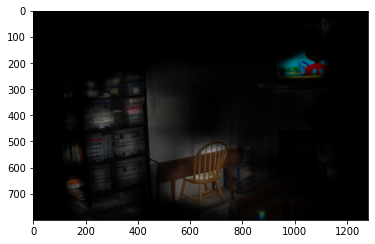

In [ ]:
#@title Sample Show { display-mode: "form" }
img = cv2.imread("./000000003877.jpg")
# cv2_imshow(img)
height, width = img.shape[:2]
image = aug.get_transform(img).apply_image(img)
img_tensor = torch.as_tensor(image.astype("float32").transpose(2, 0, 1)).cuda()
imgList = ImageList.from_tensors([img_tensor])

model.eval()
with torch.no_grad():
    features = model.backbone(img_tensor.unsqueeze(0))
    proposals, _ = model.proposal_generator(imgList, features)
    instances, _ = model.roi_heads(img, features, proposals)
instances

mask_features = [features[f] for f in features.keys()]
pred_objectness_logits, _ = model.proposal_generator.rpn_head(mask_features)

res = torch.zeros((3, 320, 512)).detach().cuda()
for i in range(len(pred_objectness_logits)):
    x = transforms.Resize((320, 512))(pred_objectness_logits[i].squeeze(0)).cuda()
    x = sigmoid(x)
    res += x

res = res/5
res = torch.divide(res, res.max())

res = transform_single(to_pil_image(res))
res = transforms.Resize((800, 1280))(res)

img_og = Image.open("./000000003877.jpg").convert('RGB')
img_draw = img_transforms(img_og).cuda()
img = to_pil_image(img_draw*res.cuda())
plt.imshow(img)